Image Reconstruction

Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X, Y) to the pixel colors (R, G, B). Here, (X, Y) represents the coordinates of the pixels, and (R, G, B) represents the color values at those coordinates.

1. **Load Image**: Select any image of your choice.
2. **Random Fourier Features (RFF)**: Implement RFF to map pixel coordinates to color values.
3. **Linear Regression**: Use linear regression to learn the mapping.
4. **Display Results**: Show both the original and reconstructed images.
5. **Metrics**: Calculate the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

**Key Variables**:
- X, Y: Pixel coordinates.
- R, G, B: Pixel color values.


#### Importing necessary libraries

In [1]:
import torch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

2.3.0


c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importing image

In [2]:
if os.path.exists('../assets/images/dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O ../assets/images/dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("../assets/images/dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


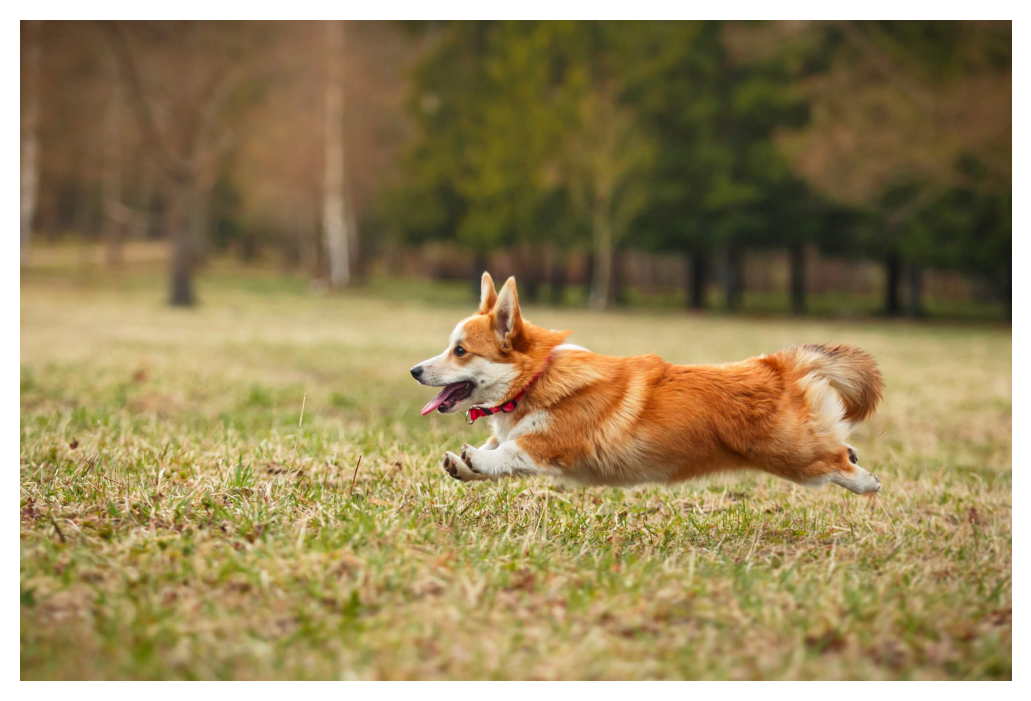

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.axis('off')
plt.show()

In [5]:
# # Read in a image from torchvision
# iitgn_img = torchvision.io.read_image("../assets/images/iitgn.jpg")
# print(iitgn_img.shape)
# plt.imshow(rearrange(iitgn_img, 'c h w -> h w c').numpy())


In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [7]:

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)


(3, 1365, 2048)


In [8]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

#### Crop the image

In [9]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

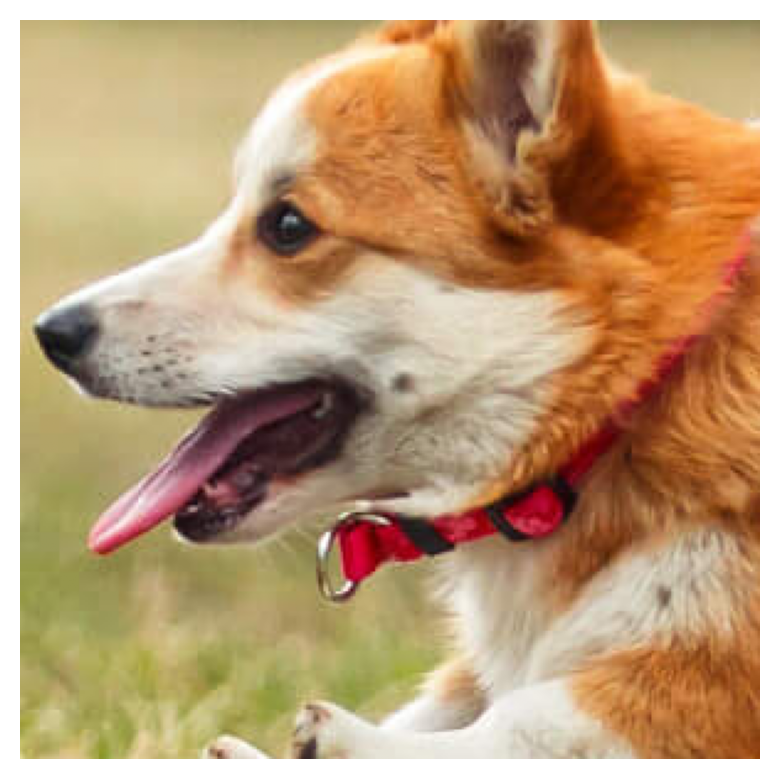

In [10]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
plt.axis('off')
plt.show()

In [11]:
crop = crop.to(device)

#### Create a coordinate map

In [12]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    print("Number of channels:", num_channels, "\nHeight:", height, "\nWidth:", width)
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    print("X shape:", X.shape)
    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    print("Y shape:", Y.shape)

    return X, Y

In [13]:
dog_X, dog_Y = create_coordinate_map(crop)

print(dog_X) # (300*300, 2)- coordinates
print(dog_Y) # (300*300, 3)- RGB values

Number of channels: 3 
Height: 300 
Width: 300
X shape: torch.Size([90000, 2])
Y shape: torch.Size([90000, 3])
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [299., 297.],
        [299., 298.],
        [299., 299.]])
tensor([[0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        ...,
        [0.6275, 0.3294, 0.0863],
        [0.5804, 0.2706, 0.0392],
        [0.5686, 0.2588, 0.0392]])


In [14]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

#### Reconstructing using Linear Model

In [15]:
torch.manual_seed(42) # Set seed for reproducibility

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [16]:
net = LinearModel(2, 3)
net.to(device)
print(net)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)


In [17]:
print("Weights:", net.linear.weight)
print("Bias:", net.linear.bias)

Weights: Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427]], requires_grad=True)
Bias: Parameter containing:
tensor([-0.3443,  0.4153,  0.6233], requires_grad=True)


In [18]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item(),losses

In [19]:
train_loss,training_losses = train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.590207
Epoch 100 loss: 0.061070
Epoch 200 loss: 0.037025
Epoch 300 loss: 0.036823
Epoch 400 loss: 0.036823
Epoch 500 loss: 0.036823
Epoch 600 loss: 0.036823
Epoch 700 loss: 0.036823
Epoch 800 loss: 0.036823
Epoch 900 loss: 0.036823


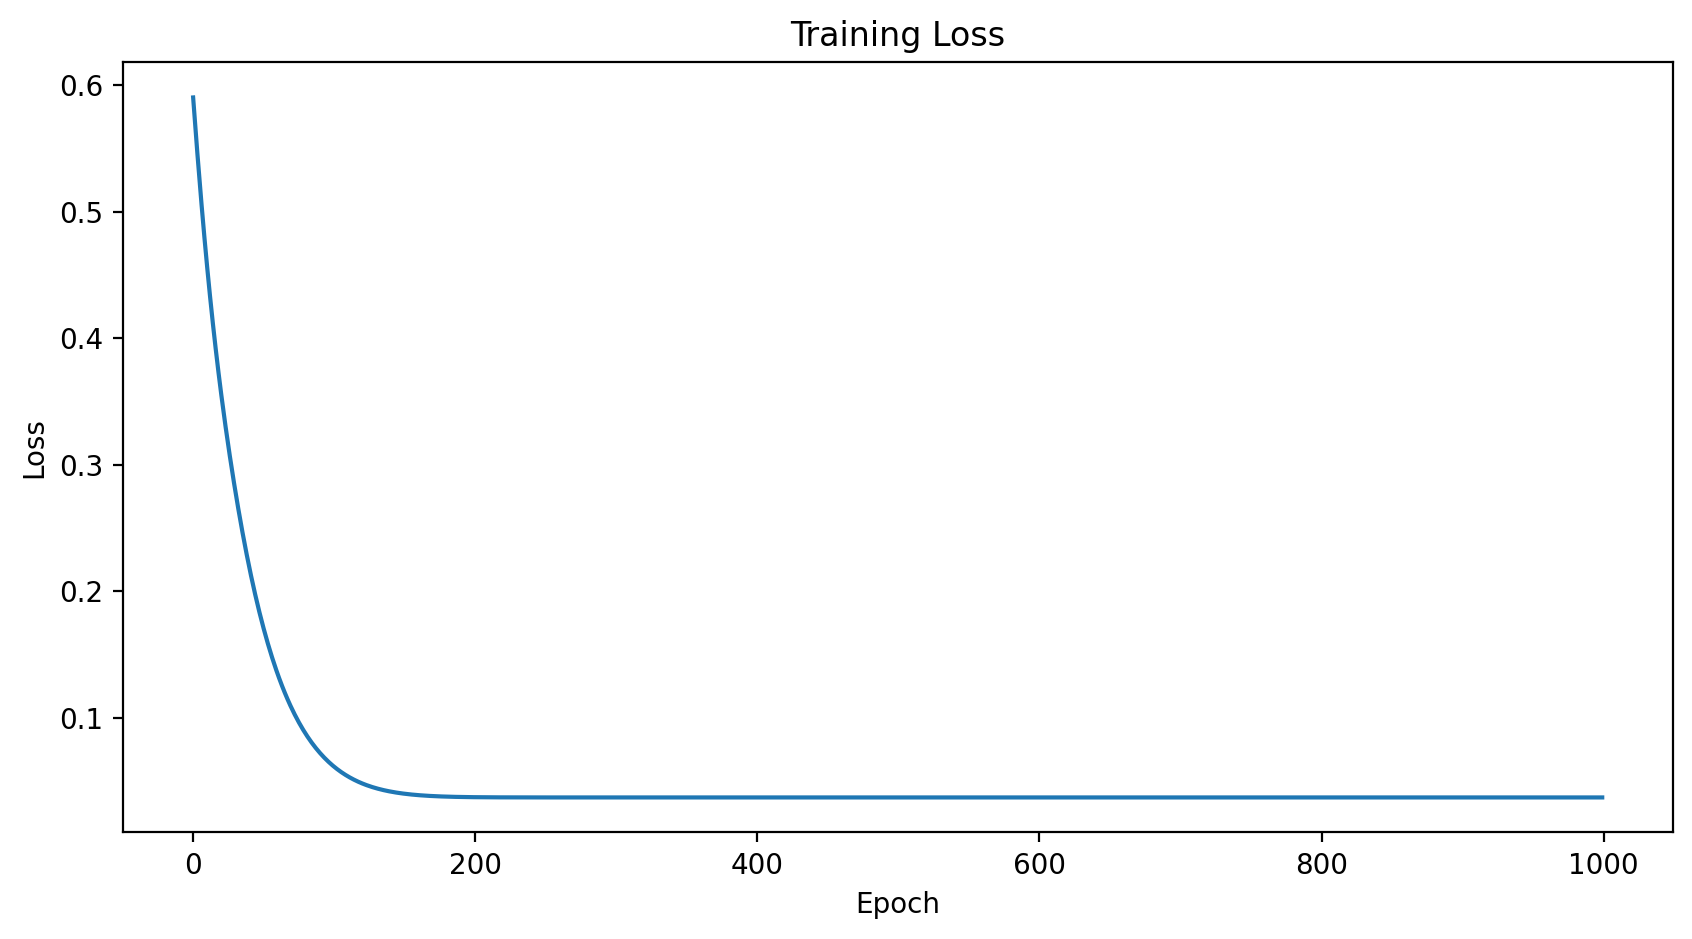

In [20]:
# plot training loss graph
plt.figure(figsize=(10, 5))

plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



In [21]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

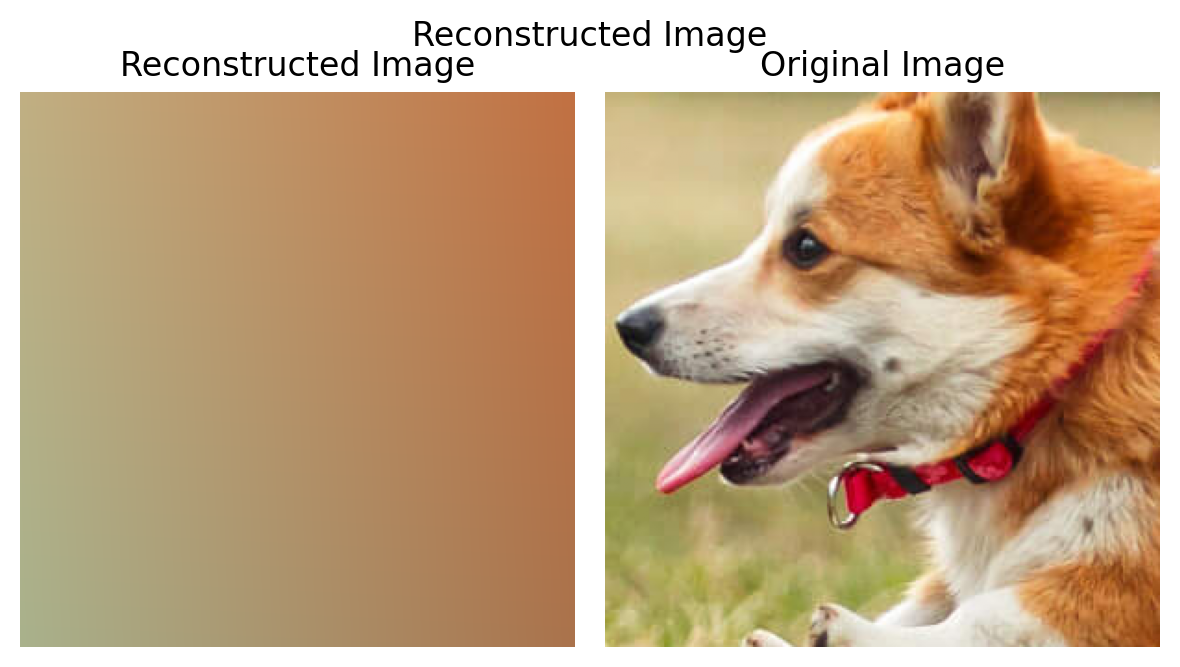

In [22]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")

#### Using Polynomial Basis Functions

In [23]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)

In [24]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, dog_Y.shape, dog_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [26]:
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train_poly_loss , train_poly_losses = train(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)

Epoch 0 loss: 0.414919
Epoch 100 loss: 0.029468
Epoch 200 loss: 0.025234
Epoch 300 loss: 0.024221
Epoch 400 loss: 0.023556
Epoch 500 loss: 0.023033
Epoch 600 loss: 0.022604
Epoch 700 loss: 0.022234
Epoch 800 loss: 0.021918
Epoch 900 loss: 0.021631
Epoch 1000 loss: 0.021380
Epoch 1100 loss: 0.021156
Epoch 1200 loss: 0.020955
Epoch 1300 loss: 0.020770
Epoch 1400 loss: 0.020604
